In [38]:
### Imports
# Modules
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import errno

# Utilities
from imgaug import augmenters as iaa
from random import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from utils import crop_resize

# Keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

# Plot in the notebook
%matplotlib inline

In [2]:
# Constants
DATA_DIR = 'data/'
CSV_FILE = 'driving_log.csv'

# Generator parameters
BATCH_SIZE = 32

# Image processing parameters
angle_treshold = 0.1
zero_discard_prob = 0.9
steering_correction = 0.25

### Load data

In [3]:
# Load csv log file
csv_file = []
with open(DATA_DIR+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [4]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.2)

### Transformation functions

In [5]:
# Image transformations
# Transformation list:
tr_list = [iaa.Add((-75, 75)), # change brightness of images (by -10 to 10 of original value)
           iaa.Multiply((0.5, 2.0)),
           iaa.ContrastNormalization((0.5, 2.0)), # improve or worsen the contrast
           iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
           iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))]
seq = iaa.SomeOf((0,1), tr_list)

In [6]:
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
path = DATA_DIR + csv_file[sample_idx][0].strip()
sample_image = cv2.imread(path)
sample_angle = csv_file[sample_idx][3]

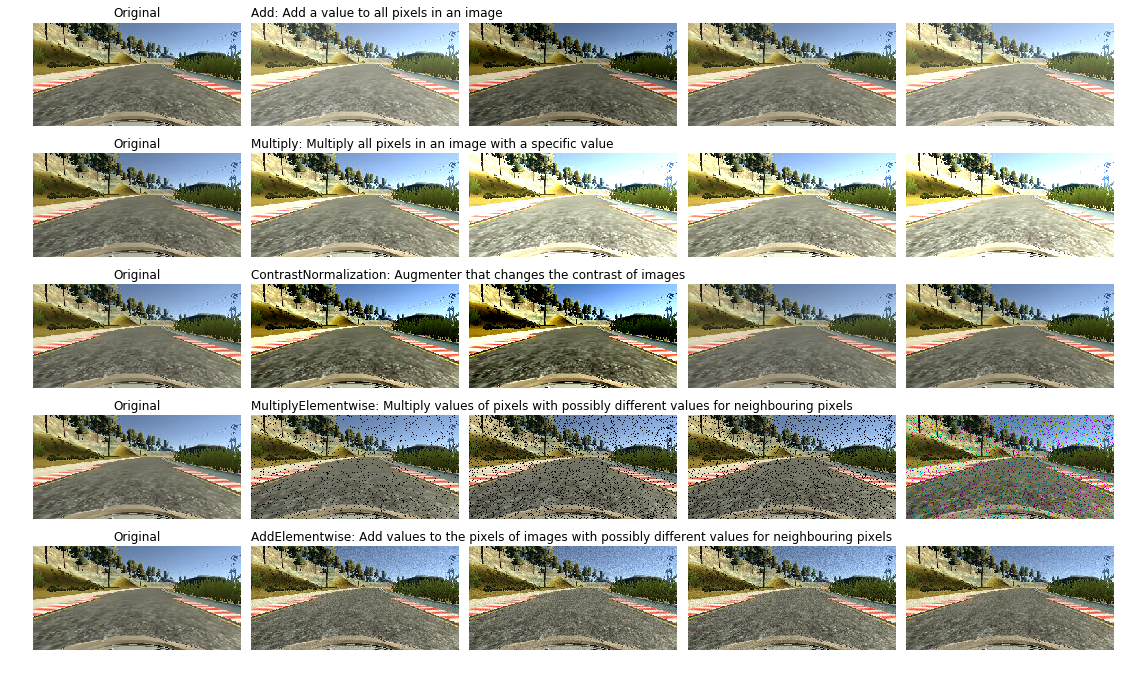

In [7]:
### Test image transformations
# Graph paramters
plot_width, plot_height = 15, 9
grid_rows, grid_cols = 5, 5
sample_size = grid_rows * grid_cols 

# Plot 
fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for tr_fn in tr_list:
    # Print non-transformed image
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original')
    counter += 1
    # Print transformed images
    tr_images = tr_fn.augment_images([sample_image]*(grid_cols-1))
    print_title = True
    for tr_image in tr_images:
        imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
        imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title('{}: {}'.format(tr_fn.name[7:],' '.join(tr_fn.__doc__.split('.')[0].split())), loc='left')
            print_title = False
        counter += 1

### Create generators

In [16]:
def transformed_data_generator(csv_file, data_dir = DATA_DIR,
                               zero_discard_prob = zero_discard_prob, forced_camera = None,
                               batch_size = BATCH_SIZE,
                               image_load = True, resize = True):
    
    # Camera parameters
    cameras = ['center', 'left', 'right']
    cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right
    cameras_steering_corretion = {'center':0, 'left':steering_correction, 'right':-steering_correction}
    
    num_samples = len(csv_file)
    
    cycles = 0
    
    while 1: # Loop forever so the generator never terminates
        
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        for idx in range(0, num_samples):
            
            angle = float(csv_file[idx][3])
            ### Discard angles below treshold with certain prob
            if angle < angle_treshold and random() < zero_discard_prob:
                continue
            counter += 1

            ### Randomly choose center, left or right image
            # Get random camera 0:center, 1:left, 2:right 
            camera = np.random.choice(cameras)
            if forced_camera:
                camera = forced_camera
            file_name = csv_file[idx][cameras_index[camera]].split('/')[-1]
            path = data_dir + 'IMG/' + file_name
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            # Adjust angle
            angle += cameras_steering_corretion[camera]            
            
            ### Random flip image with 0.5 prob
            if random() > 0.5:
                image = cv2.flip(image,1)
                angle *= -1.    
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                images = np.array(images)
                ### Randomly apply image transformation
                if image_load:
                    images = seq.augment_images(images)

                ### Resize images
                if resize and image_load:
                    images = [crop_resize(image) for image in images]
                
                X_train = np.array(images)
                y_train = np.array(angles)
                
                counter = 0
                images = []
                angles = []
                
                yield shuffle(X_train, y_train)

In [17]:
def original_data_generator(csv_file, data_dir = DATA_DIR, batch_size = BATCH_SIZE, image_load = True, resize = True):
    
    num_samples = len(csv_file)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        
        for idx in range(0, num_samples):
            
            file_name = csv_file[idx][0].split('/')[-1]
            path = data_dir + 'IMG/' + file_name
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            angle = float(csv_file[idx][3])
            counter += 1
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                images = np.array(images)
                ### Resize images
                if resize:
                    images = [crop_resize(image) for image in images]
                
                X_train = np.array(images)
                y_train = np.array(angles)
                
                counter = 0
                images = []
                angles = []
                
                yield shuffle(X_train, y_train)

In [18]:
train_data_generator = transformed_data_generator(csv_train)
valid_data_generator = original_data_generator(csv_valid)

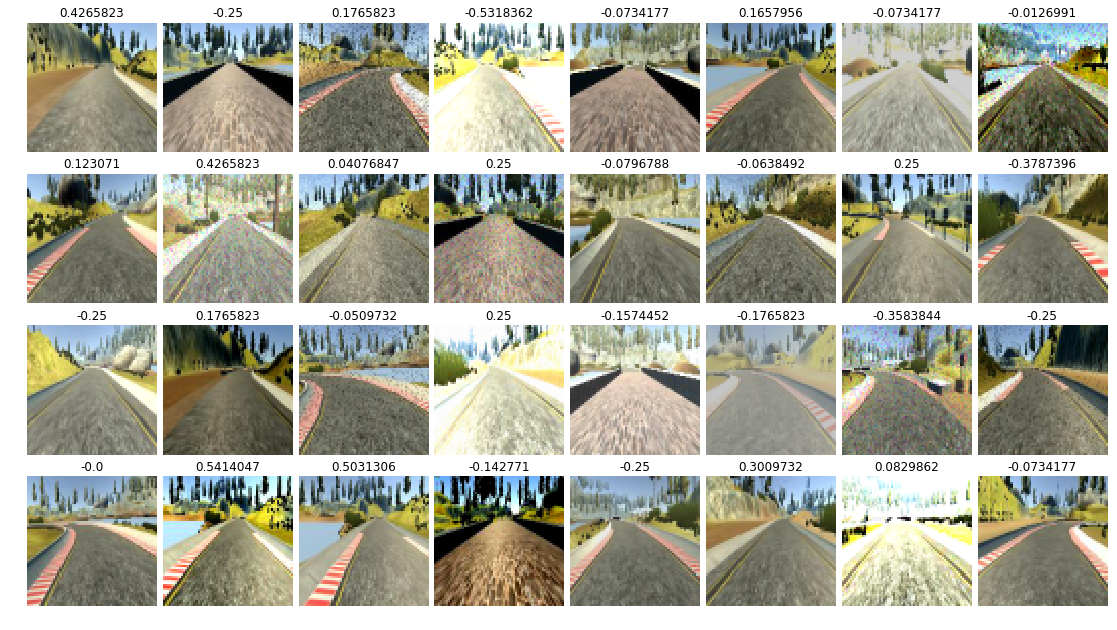

In [19]:
# Test transformed data generator
for images, angles in train_data_generator:
    break

plot_width, plot_height = 15, 8.3
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images, angles):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title(angle)

Discard angles below 0.100000 with 90.000000% prob


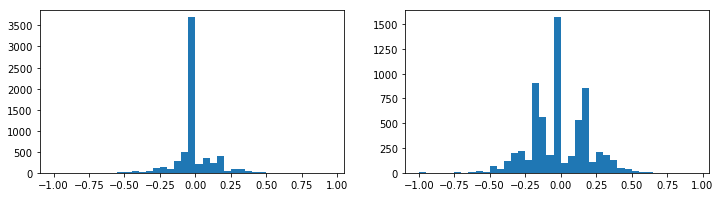

In [21]:
sample_size = 200

print('Discard angles below {:f} with {:%} prob'.format(angle_treshold, zero_discard_prob))

tr_angles = []
counter = 0
for images, angles in transformed_data_generator(csv_train, image_load = False, zero_discard_prob = .9, forced_camera = 'center'):
    counter += 1
    tr_angles = np.concatenate((tr_angles, angles))
    if counter > sample_size: break

or_angles = []
counter = 0
for images, angles in original_data_generator(csv_train, image_load = False):
    counter += 1
    or_angles = np.concatenate((or_angles, angles))
    if counter > sample_size: break        
        
buckets = np.arange(-1,1,0.05)

fig = plt.figure(figsize = (12, 3))
#fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

hstplt = fig.add_subplot(1, 2, 1)
hist = hstplt.hist(or_angles, bins = buckets)

hstplt = fig.add_subplot(1, 2, 2)
hist = hstplt.hist(tr_angles, bins = buckets)

### Define model

In [32]:
learning_rate = 0.0001
keep_prob = 0.5
def create_nv_model():
    
    # Define nvidia model
    model = Sequential()
    # model.add(Cropping2D(cropping=((30,25),(0,0)), input_shape = (160, 320, 3)))
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    
    model.add(Conv2D(24, (5, 5), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(36, (5, 5), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(48, (5, 5), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same',  strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Flatten())
    
    model.add(Dense(1164, activation = 'relu'))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1))
    
    # adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss = 'mse', optimizer = Adam(learning_rate))
    return model

### NVidia model with generator

In [34]:
nv_model = create_nv_model()
nv_history_object = nv_model.fit_generator(transformed_data_generator(csv_train),
                                steps_per_epoch = len(csv_train)/BATCH_SIZE,
                                epochs=5, #FLAGS.epochs,
                                validation_data = original_data_generator(csv_valid), validation_steps = len(csv_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = nv_model.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

Epoch 1/5
201/200 [==============================] - 105s - loss: 0.0801 - val_loss: 0.0157
Epoch 2/5
201/200 [==============================] - 127s - loss: 0.0503 - val_loss: 0.0234
Epoch 3/5
201/200 [==============================] - 128s - loss: 0.0382 - val_loss: 0.0177
Epoch 4/5
201/200 [==============================] - 119s - loss: 0.0367 - val_loss: 0.0161
Epoch 5/5
201/200 [==============================] - 113s - loss: 0.0332 - val_loss: 0.0180
Predicted	Angle	Abs. diff.
0.034677	0.000000	0.034677
-0.167862	-0.021780	0.146082
0.223753	0.253131	0.029378
-0.266820	-0.059757	0.207063
0.152729	0.000000	0.152729
0.154645	0.000000	0.154645
-0.209740	-0.373071	0.163331
0.170232	0.000000	0.170232
0.126451	0.052191	0.074259
-0.136069	0.000000	0.136069
0.004658	-0.116723	0.121381
0.102336	0.090466	0.011870
-0.076770	-0.031274	0.045496
0.083613	0.071328	0.012285
-0.144200	0.000000	0.144200
0.111385	0.071328	0.040057
0.144139	0.042623	0.101516
0.175312	0.147877	0.027435
0.170616	0.00000

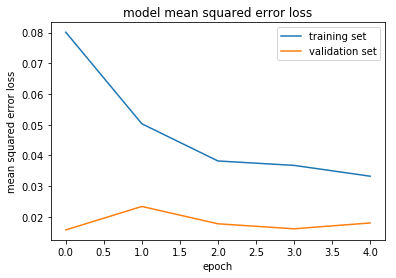

In [36]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [42]:
# Save model
model_name = 'models/nv_model.h5'

# Delete previous files:
def delete_file(file_name):
    try:
        os.remove(file_name)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise
delete_file(model_name)

# Save model
nv_model.save(model_name)

In [40]:
# Save model
weights_name = 'models/nv_model.h5'
model_name = 'models/nv_model.json'

# Delete previous files:
def delete_file(file_name):
    try:
        os.remove(file_name)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise
delete_file(weights_name)
delete_file(model_name)
        
# Convert to json:
json_string = nv_model.to_json()

# Save model
with open(model_name, 'w') as outfile:
    json.dump(json_string, outfile)
nv_model.save_weights(weights_name)

## Fine tune model

In [ ]:
nv_model_ft = load_model('models/nv_model.h5')

In [ ]:
for idx_layer in range(len(nv_model_ft.layers)):
    print(idx_layer, nv_model_ft.layers[idx_layer])
    
for layer in nv_model_ft.layers:
    layer.trainable = True
# for layer in nv_model_ft.layers[:-8]:
#     print(layer)
#     layer.trainable = False

In [ ]:
# for layer in nv_model_ft.layers[:]:
#     layer.trainable = False
# adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.0005, momentum=0.0, decay=0.9, nesterov=False)
nv_model_ft.compile(loss = 'mse', optimizer = sgd)
nv_model_ft.summary()

In [ ]:
### Get data for fine tuning
FT_DATA_DIR = 'getting-out-data/'
FT_DATA_FILE = 'driving_log.csv'

# Load csv log file
csv_ft_file = []
with open(FT_DATA_DIR+FT_DATA_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_ft_file.append(line)
# Split csv in train and validation sets
csv_ft_train, csv_ft_valid = train_test_split(csv_ft_file, test_size = 0.2)

In [ ]:
nv_history_object = nv_model_ft.fit_generator(transformed_data_generator(csv_ft_train, data_dir = 'getting-out-data/', zero_discard_prob = 2.0), steps_per_epoch = len(csv_ft_train)/BATCH_SIZE,
                                 epochs=5, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_ft_valid, data_dir = 'getting-out-data/'), validation_steps = len(csv_ft_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = nv_model_ft.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [ ]:
### Get data for fine tuning
FT_DATA_DIR = 'new-data/'
FT_DATA_FILE = 'driving_log.csv'

# Load csv log file
csv_ft_file = []
with open(FT_DATA_DIR+FT_DATA_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_ft_file.append(line)
# Split csv in train and validation sets
csv_ft_train, csv_ft_valid = train_test_split(csv_ft_file, test_size = 0.2)

In [ ]:
nv_history_object = nv_model_ft.fit_generator(transformed_data_generator(csv_ft_train, data_dir = 'new-data/'), steps_per_epoch = len(csv_ft_train)/BATCH_SIZE,
                                 epochs=10, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_ft_valid, data_dir = 'new-data/'), validation_steps = len(csv_ft_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = nv_model_ft.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [ ]:
# Save model
nv_model_ft.save('models/nv_model_ft.h5')